doc = """
    This file contains the real implementation for decoding the images. 
    
    The other file, AllAtOnce_ConvNet was used for data preparation.
"""

In [258]:
## import libraries

import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import pylab as P
import skimage
import h5py
import PIL.Image as Image
import functools
from sklearn.cross_validation import train_test_split as ttsplit
import cPickle as pickle

In [259]:
#set the random seed so that we get consistent results across runs
tf.set_random_seed(1234)

In [260]:
# helpers to read files off the disk
## TODO: move helpers to their own module

def read_pickle(f_name):
    f = open(f_name, 'r')
    return pickle.load(f)

data_path = os.path.join(os.path.split(os.getcwd())[0], 'data')

def get_data_path(f_name):
    return os.path.join(data_path, f_name)

In [261]:
# read the data off the disk

bundles = [read_pickle(get_data_path(f_name)) for f_name in ['train_images.pkl', 'test_images.pkl', 'valid_images.pkl']]
train_bundle, test_bundle, valid_bundle = bundles

train_images = train_bundle['X']
test_images = test_bundle['X']
valid_images = valid_bundle['X']

train_labels = train_bundle['y']
test_labels = test_bundle['y']
valid_labels = valid_bundle['y']
        

In [262]:
## let's carry out some exploratory analysis
## let's plagiarise our plot code from the other file
## TODO: figure out if ipynb can import other ipynb. actually, no. move code to .py

labels = range(11)

def plot_label_data(x,y, name, x_label, y_label, width=1./3, color='blue'):
    plt.bar(x, y, width = width, color = color)
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    


def plot_label_distribution(label_data, name):
    sizes = np.array([len(np.where(label_data==l)[0]) for l in labels], dtype=np.float32)
    print sizes/sum(sizes)
    plot_label_data(labels, sizes, name, 'Digits', 'Frequency')
        


[ 0.02224263  0.09669932  0.15948628  0.06329712  0.03403989  0.03043057
  0.02521426  0.02574992  0.02117131  0.02034231  0.50132638]


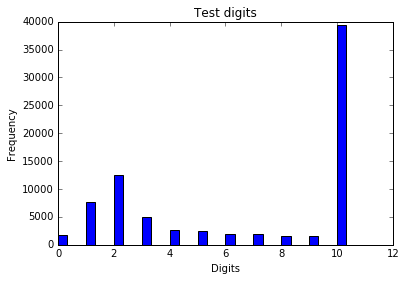

[ 0.03597106  0.08391263  0.12338489  0.13160102  0.05236414  0.04295241
  0.0335356   0.03520131  0.02867919  0.02772808  0.40466967]


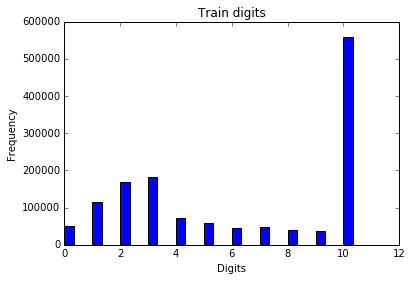

[ 0.02534728  0.09070784  0.14137474  0.09253418  0.04659915  0.03566882
  0.02999613  0.02963639  0.02410205  0.02476617  0.45926726]


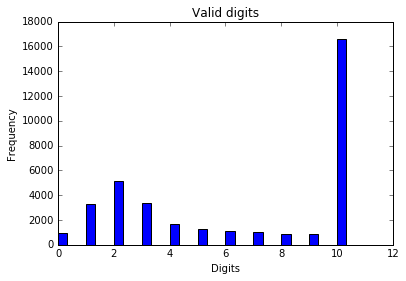

In [263]:
plot_label_distribution(test_labels, 'Test digits')
plot_label_distribution(train_labels, 'Train digits')
plot_label_distribution(valid_labels, 'Valid digits')


Extremely interesting that Benford's law has been abandoned here. 

Obviously, 
- the cropped images and the full images are not the same
- the 10 stands for the blank and it is natural that it appears so frequently

In [264]:
## plot distributions of lengths
from collections import Counter

def get_lengths(label_data):
    return map(lambda row: len(np.where(row != 10)[0]), label_data)

## check how many of each kind we have
def count_distribution(label_data):
    lengths = get_lengths(label_data)
    return Counter(length)

def plot_count_distribution(label_data, name):
    
    print len(label_data)
    counts = Counter(label_data)
    keys  = counts.keys()
    sizes = counts.values()
    
    print counts.keys()
    print counts.values()
    assert(sum(counts.values()) == len(label_data))
    plot_label_data(keys, sizes, name, 'Sizes', 'Frequency', width = 2./3)



229731
[1, 2, 3, 4, 5]
[13681, 86714, 113711, 15503, 122]


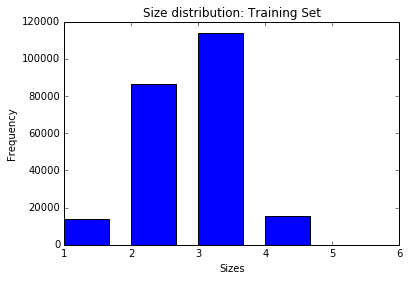

6023
[1, 2, 3, 4, 5]
[841, 3142, 1769, 269, 2]


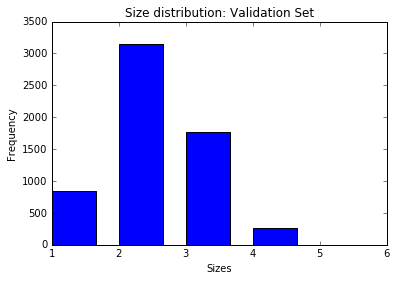

13068
[1, 2, 3, 4, 5]
[2483, 8356, 2081, 146, 2]


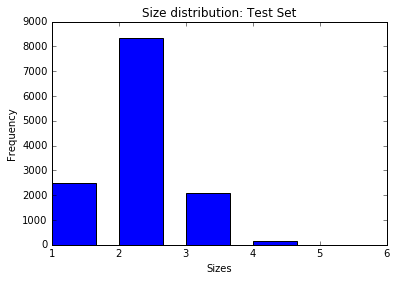

In [265]:
plot_count_distribution(train_labels[:,0], "Size distribution: Training Set")
plot_count_distribution(valid_labels[:,0], "Size distribution: Validation Set")
plot_count_distribution(test_labels[:,0], "Size distribution: Test Set")

# Let's try some learning

In [266]:
#define an accuracy measure for this model
def accuracy(predictions, labels):
    """
        How many places did we get right?
    """
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels)) / labels.size

In [267]:
## we use 64 images at a time
batch_size = 64

# each image is image_size x image_size and has one channel
image_size = 32
num_channels = 1

# convolve layers -> we convolve with a 5x5 patch and increase the depth as we go along
patch_size = 5

## first, we get to a depth of 16 at the end of one stage of convolution
depth1 = 16

# then we proceed to a depth of 32 for the convolved data
depth2 = 32


## droput probability of 0.99 to regularize the network
keep_prob_dropout = 0.99

## Fully connected network at the end
num_hidden = 64

# each of our variables can be either of 11 values
num_labels = 11 ## 10 digits (0-9) + we have a blank space

# create a tensorflow graph
graph = tf.Graph()

## use this graph

with graph.as_default():

  # Input data.
  # train data
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

  ## test and validation data
  tf_valid_dataset = tf.constant(valid_images)
  tf_test_dataset = tf.constant(test_images)
  
  # Variables.
  ## convolution layer 1
  layer1_weights = tf.get_variable("conv1",
                                   shape = [patch_size, patch_size, num_channels, depth1],
                                   initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                  )
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  
  ## convolution layer 2
  layer2_weights = tf.get_variable("conv2",
                                   shape = [patch_size, patch_size, depth1, depth2],
                                   initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                  )
  layer2_biases = tf.Variable(tf.zeros([depth2]))

  ## hidden layer
  layer3_weights = tf.Variable(tf.truncated_normal(
    [patch_size * patch_size * depth2, num_hidden], stddev=0.1)) 
  layer3_biases = tf.Variable(tf.zeros([num_hidden]))

  ## 5 predictors here for the five places
  ## op layer
  op1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))


  # The actual model
  def model(data, is_training = False):
    
    ## convolve the input data
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID') # -> 28x28x1x16
    
    ## pool it using max_pool
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1,2,2,1], padding = 'SAME') ## 
    
    ## pass it through a relu to let the positive signals through
    hidden = tf.nn.relu(pool + layer1_biases)
    
    ## repeat the same all over
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    ## pass this to the hidden layer
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    ## use dropouts (but only if training)
    if is_training:
        hidden  = tf.nn.dropout(hidden, keep_prob=keep_prob_dropout)

    ## predict the outputs using the op projection layers
    digit_1 = tf.matmul(hidden, op1_weights) + op1_biases
    digit_2 = tf.matmul(hidden, op2_weights) + op2_biases
    digit_3 = tf.matmul(hidden, op3_weights) + op3_biases
    digit_4 = tf.matmul(hidden, op4_weights) + op4_biases
    digit_5 = tf.matmul(hidden, op5_weights) + op5_biases
    
    # return the predicted outputs
    return (digit_1, digit_2, digit_3, digit_4, digit_5)

  # Get the output from the model function
  d1, d2, d3, d4, d5 = model(tf_train_dataset, True)

  # Compute the loss -> the average loss for each digit
  loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(d1, tf_train_labels[:,1])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, tf_train_labels[:,2])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, tf_train_labels[:,3])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, tf_train_labels[:,4])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, tf_train_labels[:,5])
    )
    
  # Optimize this loss
  global_step = tf.Variable(0)  # count the number of steps taken.
  # set the learning the rate as variable
  learning_rate = tf.train.exponential_decay(0.08, global_step, 2500, 0.98)
    
  ## define the optimization function
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
  optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.FtrlOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)  

  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])
  valid_model  = model(tf_valid_dataset)
  valid_prediction = tf.pack([tf.nn.softmax(valid_model[idx]) for idx in range(5)]) #d in [valid_model]])
  test_model  = model(tf_test_dataset)
  test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])

In [268]:
#run this for 150k steps
num_steps = 150001

# define a tensorflow session
with tf.Session(graph=graph) as session:
  # initialize variables
  tf.initialize_all_variables().run()
  print('Initialized')

  for step in range(num_steps):
    # prepare feed data
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_images[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    ## get the output
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels[:,1:6]))

  # calculate final results
  final_predictions = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(final_predictions, test_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 12.576935
Minibatch accuracy: 5.9%
Validation accuracy: 3.9%
Minibatch loss at step 2500: 1.527837
Minibatch accuracy: 91.2%
Validation accuracy: 89.9%
Minibatch loss at step 5000: 1.171208
Minibatch accuracy: 91.9%
Validation accuracy: 91.5%
Minibatch loss at step 7500: 0.841072
Minibatch accuracy: 94.4%
Validation accuracy: 92.3%
Minibatch loss at step 10000: 0.998764
Minibatch accuracy: 90.6%
Validation accuracy: 92.3%
Minibatch loss at step 12500: 0.977042
Minibatch accuracy: 94.4%
Validation accuracy: 92.8%
Minibatch loss at step 15000: 0.969641
Minibatch accuracy: 94.4%
Validation accuracy: 92.6%
Minibatch loss at step 17500: 1.023044
Minibatch accuracy: 93.8%
Validation accuracy: 92.7%
Minibatch loss at step 20000: 0.734750
Minibatch accuracy: 95.6%
Validation accuracy: 92.6%
Minibatch loss at step 22500: 0.579110
Minibatch accuracy: 96.9%
Validation accuracy: 93.2%
Minibatch loss at step 25000: 0.986045
Minibatch accuracy: 95.0%
Validation 

94.6 is not too bad!

In [269]:
# how did we do at decoding entire strings?
def whole_string_accuracy(predictions, labels):
    """
        How many strings did we get entirely right?
    """
    ## compare a row at a time
    equal_rows = [np.all(predictions[idx,:] == labels[idx,:]) for idx in range(labels.shape[0])]
    return (100.0 * np.sum(equal_rows))/ labels.shape[0]

In [270]:
predictions = np.argmax(final_predictions, 2).T
print whole_string_accuracy(predictions, test_labels[:,1:6])

80.3183348638


Clearly there is a considerable distance to go as far as improvement is concerned!

In [271]:
def display_images(images, labels, rand_indices=None):
    """
        Display random images from a set and return indices so we can match the results
    """
    display_size = 10
    display_per_row = 10
    num_rows = display_size/display_per_row
    if rand_indices is None:
        rand_indices = np.random.randint(0, test_images.shape[0], size=display_size)
    row_size = 20
    col_size = 20

    fig = P.figure(figsize=(20, 20))
    for idx in range(len(rand_indices)):
        orig_idx = rand_indices[idx]
        display_row_idx = int(idx/display_per_row) + 1
        display_col_idx = idx%display_per_row +1
        a=fig.add_subplot(display_row_idx, display_per_row, display_col_idx, frameon=False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
        a.imshow(images[orig_idx,:,:,0].T, cmap="Greys_r")
        img_label = labels[orig_idx,:]
        a.set_title(''.join([str(x) for x in img_label[img_label != 10]]))
    
    return rand_indices

array([12615, 12438,  9049,  7491,  1907, 11572,  9589,  5561,  5292,  6609])

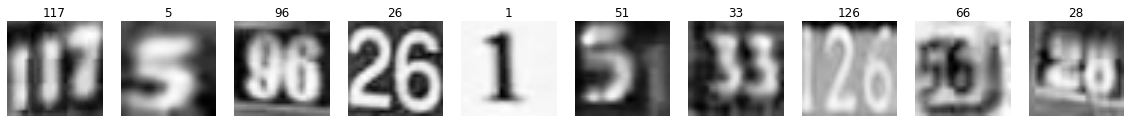

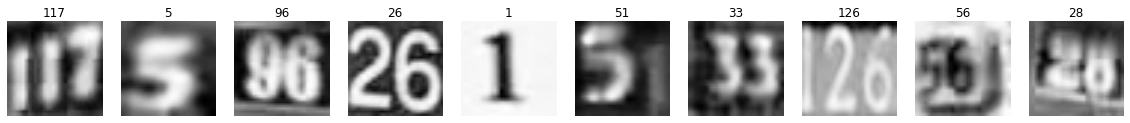

In [272]:
# display some predictions
chosen_images = display_images(test_images, predictions)
# display the originals too
display_images(test_images, test_labels[:,1:], chosen_images)

In [273]:
## calculate f1 score of all 11 classes in the data
from sklearn.metrics import f1_score

## reshape the predictions and outputs
test_labels_reshape = test_labels[:,1:6].reshape(-1,1)
predictions_reshape = predictions.reshape(-1, 1)

## Exclude the blank spaces when determining F1 scores
actual_digit_labels = range(10)
f1_weighted = f1_score(test_labels_reshape, predictions_reshape, actual_digit_labels, average='weighted')
f1_unweighted = f1_score(test_labels_reshape, predictions_reshape, actual_digit_labels, average='macro')
f1_scores  = f1_score(test_labels_reshape, predictions_reshape, actual_digit_labels, average=None)

print "Weighted F1: ", f1_weighted
print "Unweighted F1: ", f1_unweighted

print "Classwise F1"
for k,v in zip(labels, f1_scores):
    print "\tDigit: {}, f1: {}".format(k,v)

Weighted F1:  0.883035028858
Unweighted F1:  0.874328998364
Classwise F1
	Digit: 0, f1: 0.875982042649
	Digit: 1, f1: 0.907848496681
	Digit: 2, f1: 0.911785799665
	Digit: 3, f1: 0.859981933153
	Digit: 4, f1: 0.904619076185
	Digit: 5, f1: 0.88799321171
	Digit: 6, f1: 0.849084611578
	Digit: 7, f1: 0.8881136307
	Digit: 8, f1: 0.822716346154
	Digit: 9, f1: 0.835164835165


In [274]:
# check the accuracy wrt number of digits in the outcome
predicted_lengths = get_lengths(predictions)

valid_lengths = range(1,6)


f1_l_weighted = f1_score(test_labels[:,0], predicted_lengths, valid_lengths, average='weighted')
f1_l_unweighted = f1_score(test_labels[:,0], predicted_lengths, valid_lengths, average='macro')
f1_l_scores  = f1_score(test_labels[:,0], predicted_lengths, valid_lengths, average=None)

In [275]:
print "Weighted F1: ", f1_l_weighted
print "Unweighted F1: ", f1_l_unweighted

print "Classwise F1"
for k,v in zip(valid_lengths, f1_l_scores):
    print "\tDigit: {}, f1: {}".format(k,v)

Weighted F1:  0.951981521417
Unweighted F1:  0.735418751147
Classwise F1
	Digit: 1, f1: 0.945085555113
	Digit: 2, f1: 0.965425692391
	Digit: 3, f1: 0.914123491838
	Digit: 4, f1: 0.852459016393
	Digit: 5, f1: 0.0


This is terrible - we messed up both the examples with 5 digits in them and that messed up our overall F1 score!

Clean up the code to make it like a sklearn model.

This will enable us to use sklearn primitives.

## The Final Cut

Create a Model class that behaves like an SKLearn class. This will help us run meaningful validations without having to change the code manually each time. We can generalize it later.

In [321]:
from sklearn.base import BaseEstimator

PARAM_ALPHA_NAME = 'alpha'
PARAM_OPTIMIZER_NAME = 'optimizer'
PARAM_OPTIMIZER_VAL_GRADIENT_DESCENT = 'GradientDescent'
PARAM_OPTIMIZER_VAL_ADAM = 'Adam'

class SVHNModel(BaseEstimator):
    def get_params(self, deep=False):
        """
            We currently support alpha and optimizer
        """
        return {PARAM_ALPHA_NAME: self.alpha, PARAM_OPTIMIZER_NAME: self._opt}
    
    
    def set_params(self, **d):
        if 'optimizer' in d:
            self.optimizer = d['optimizer']
        if 'alpha' in d:
            self.alpha  = d['alpha']

    
    # Model.
    def model(self, data, is_training = False):
        with self.graph.as_default():
            conv = tf.nn.conv2d(data, self.layer1_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.avg_pool(conv, [1, 2, 2, 1], [1,2,2,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer1_biases)
            shape = hidden.get_shape().as_list()
            print shape

            conv = tf.nn.conv2d(hidden, self.layer2_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer2_biases)
            shape = hidden.get_shape().as_list()
            print shape
            
            conv = tf.nn.conv2d(hidden, self.layer2_5_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.max_pool(conv, [1,3,3,1], [1,3,3,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer2_5_biases)
            
            shape = hidden.get_shape().as_list()
            print shape
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden1 = tf.nn.relu(tf.matmul(reshape, self.layer3_weights) + self.layer3_biases)
            
            if is_training:
                hidden1  = tf.nn.dropout(hidden1, keep_prob=self._keep_prob_dropout)
        
            hidden = tf.nn.relu(tf.matmul(hidden1, self.layer3_5_weights) + self.layer3_5_biases)
            if is_training:
                hidden  = tf.nn.dropout(hidden, keep_prob=self._keep_prob_dropout)
                
            digit_1 = tf.matmul(hidden, self.op1_weights) + self.op1_biases
            digit_2 = tf.matmul(hidden, self.op2_weights) + self.op2_biases
            digit_3 = tf.matmul(hidden, self.op3_weights) + self.op3_biases
            digit_4 = tf.matmul(hidden, self.op4_weights) + self.op4_biases
            digit_5 = tf.matmul(hidden, self.op5_weights) + self.op5_biases

            return (digit_1, digit_2, digit_3, digit_4, digit_5)

    
    def __init__(self,
                 graph=None,
                 session=None,
                 verbose  = True,
                 alpha = 0.08,
                 decay_rate = 0.95,
                 decay_epochs = 1,
                 optimizer = tf.train.GradientDescentOptimizer,
                 keep_prob_dropout = 0.99,
                 batch_size = 64,
                 train_epochs = 30
                ):
        
        image_size=32
        num_channels = 1
        patch_size = 5
        patch_size2 = 3
        depth1 = 16
        depth2 = 32
        num_hidden1 = 64
        num_hidden = num_hidden2  = 32
        num_labels = 11
        
        # intialize some of these variables
        self.verbose = verbose
        self._alpha = alpha
        self._opt = optimizer
        self._decay_rate = decay_rate
        self._decay_epochs  = decay_epochs
        self._keep_prob_dropout = keep_prob_dropout
        self._batch_size = batch_size
        self._train_epochs = train_epochs
        self._optimizer = None
        
        ## delve into the graph
        self.graph = graph
        self.session = session
            
        # Input data.
        self.tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        self.tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
        
          # Variables.
          # Layer 1 - convolutional layer
        self.layer1_weights = tf.get_variable("conv1",
                                           shape = [patch_size, patch_size, num_channels, depth1],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer1_biases = tf.Variable(tf.zeros([depth1]))


        # Layer 2 - convolutional layer
        self.layer2_weights = tf.get_variable("conv2",
                                           shape = [patch_size, patch_size, depth1, depth2],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer2_biases = tf.Variable(tf.zeros([depth2]))

        
        # Layer 2.5 - convolutional layer
        self.layer2_5_weights = tf.get_variable("conv2_5",
                                           shape = [patch_size2, patch_size2, depth2, depth3],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer2_5_biases = tf.Variable(tf.zeros([depth3]))

        
          # Layer 3 - hidden layer
        self.layer3_weights = tf.Variable(tf.truncated_normal(
            [1 * 1 * depth3, num_hidden1], stddev=0.1))
        self.layer3_biases = tf.Variable(tf.zeros([num_hidden1]))
        
        self.layer3_5_weights = tf.Variable(tf.truncated_normal(
            [num_hidden1, num_hidden2], stddev=0.1))
        self.layer3_5_biases = tf.Variable(tf.zeros([num_hidden2]))
        

          ## Outputs- projection for each digit
        self.op1_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
        self.op1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op2_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
        self.op2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op3_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op4_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op5_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        
          # Training computation.
        d1, d2, d3, d4, d5 = self.model(self.tf_train_dataset, True)
        self.loss = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(d1, self.tf_train_labels[:,1])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, self.tf_train_labels[:,2])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, self.tf_train_labels[:,3])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, self.tf_train_labels[:,4])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, self.tf_train_labels[:,5])
            )

          # Optimizer.
          # So confusing to track lr and alpha
          # use lr when dealing within tf land 
          # use alpha to communicate with outside world
        self._lr = tf.Variable(0.0, trainable = False) 
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._tf_lr_update = tf.assign(self._lr, self._new_lr)
          
        self.optimizer = optimizer
          #print self._optimizer #self._opt(self._lr)
          
          # Predictions for the training, validation, and test data.
        self.train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])

    
    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, _lr):
        ## this requires a retrain
        ## reinit all variables, et al?
        self.session.run(self._tf_lr_update, feed_dict={self._new_lr: _lr})
    
    @property
    def optimizer(self):
        return self._opt

    @optimizer.setter
    def optimizer(self, opt):
        ## this requires a retrain
        ## reinit all variables, et al?
        self._opt = opt
        self._optimizer = opt(self._lr).minimize(self.loss)

    
    def fit(self, train_images, train_labels):
          """
            X: train_images
            y: train_labels
          """
        ## calc num steps per epoch
          num_steps = train_labels.shape[0]/self._batch_size - 1
        
        # run the session
        #with tf.Session(graph=self.graph) as session: #self.session.as_default():
          tf.initialize_all_variables().run()
          if self.verbose:
              print('Initialized variables, fitting data')
            
          for epoch_id in range(self._train_epochs):
            lr_decay = self._decay_rate ** (epoch_id/self._decay_epochs)
            lr_rate = self._alpha * lr_decay
            self.alpha = lr_rate
              
            for step in range(num_steps):
                offset = (step * self._batch_size) % (train_labels.shape[0] - self._batch_size)
                batch_data = train_images[offset:(offset + batch_size), :, :, :]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {self.tf_train_dataset : batch_data, self.tf_train_labels : batch_labels}
                _, l, predictions = self.session.run(
                  [self._optimizer, self.loss, self.train_prediction], feed_dict=feed_dict)
                if self.verbose and (step % 2500 == 0):
                  print('Minibatch loss at epoch: %d, step %d: %f' % (epoch_id, step, l))
                  print('Minibatch F1: %0.3f' % self.measure_score(batch_labels[:,1:6], np.argmax(predictions, 2).T))


    def predict(self, test_images):
        test_dataset = tf.constant(test_images)
        test_model  = self.model(test_dataset)
        test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])
        predicted_labels = self.session.run(test_prediction)
        return np.argmax(predicted_labels,2).T
    
    def measure_score(self, true_labels, predicted_labels, average = 'weighted'):
        ## reshape the labels 
        predicted_labels_1d = predicted_labels.reshape(-1,1)
        true_labels_1d = true_labels.reshape(-1,1)
        return f1_score(true_labels_1d, predicted_labels_1d, labels=range(11), average=average)
    
    def score(self, test_images, test_labels, average = 'weighted'):
        predicted_labels = self.predict(test_images)
        return self.measure_score(test_labels, predicted_labels, average)
        

In [322]:
## With that out of the way, our code should be pretty concise now!
graph = tf.Graph()
with graph.as_default(), tf.Session() as session:
    svhn_model = SVHNModel(graph, session, train_epochs=1)
    svhn_model.fit(train_images, train_labels)
    f1 = svhn_model.score(test_images, test_labels[:,1:6])
    print f1

[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
Initialized variables, fitting data
Minibatch loss at epoch: 0, step 0: 12.010099
Minibatch F1: 0.019
Minibatch loss at epoch: 0, step 2500: 2.868559
Minibatch F1: 0.835
[13068, 14, 14, 16]
[13068, 5, 5, 32]
[13068, 1, 1, 64]
0.885867093636


**Note: The bits above worked. Sadly, GridSearchCV does a deep copy for some reason which will not sit well with what we are trying. Write the validation code manually**

In [283]:
from sklearn.grid_search import GridSearchCV
## TODO: GridSearchCV needs objects to be deep-copyable -> in a rather brutish way
## so, let's soldier on with what we have and implement grid search cv ourselves

from itertools import product
hyperparams = {
                    PARAM_ALPHA_NAME: [0.08, 0.12, 0.15],
                    PARAM_OPTIMIZER_NAME: [tf.train.GradientDescentOptimizer, tf.train.AdadeltaOptimizer]
              }

params_to_try = hyperparams.keys()

Rather ironic that while looking for possible solutions to the problem of using GridSearch along with Tensorflow, i found skflow and that skflow has been included in the TensorFlow library already. It would have saved a whole lot of time and effort to use it from the beginning.

In [247]:
## generate the possible combinations as a cartesian product of the hyperparams
possible_combinations = product(hyperparams[PARAM_ALPHA_NAME], hyperparams[PARAM_OPTIMIZER_NAME])
results = {}
for combination in possible_combinations:
    ## reformulate the product as a dictionary
    kw_args = dict(zip(params_to_try, combination))
    
    ## create and run the model
    graph = tf.Graph()
    with graph.as_default(), tf.Session() as session:
        svhn_model = SVHNModel(graph, session, train_epochs=10, verbose=False, **kw_args)
        svhn_model.fit(train_images, train_labels)
        score = svhn_model.score(valid_images, valid_labels[:,1:6])
        results[score] = kw_args

In [248]:
#print results
best_result = sorted(results.keys())[-1]
print best_result, results[best_result]

0.924602143787 {'alpha': 0.08, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>}


In [323]:
# create an SVHN model with the params we found and use this on the test set
graph = tf.Graph()
with graph.as_default(), tf.Session() as session:
    best_svhn_model = SVHNModel(graph, session, train_epochs=50, verbose=False, **results[best_result])
    best_svhn_model.fit(train_images, train_labels)
    predicted_labels = best_svhn_model.predict(test_images)
    print best_svhn_model.measure_score(test_labels[:,1:6], predicted_labels)
    print best_svhn_model.measure_score(test_labels[:,1:6], predicted_labels, average=None)
    print best_svhn_model.measure_score(test_labels[:,1:6], predicted_labels, average = 'macro')

[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[13068, 14, 14, 16]
[13068, 5, 5, 32]
[13068, 1, 1, 64]
0.949857968853
[ 0.88447133  0.91287842  0.91132827  0.86595492  0.91266376  0.88592027
  0.84958005  0.88494703  0.84934829  0.851875    0.99063754]
0.890873170244


In [324]:
print whole_string_accuracy(predicted_labels, test_labels[:,1:6])

81.0988674625


In [255]:
def predict_accuracy(predictions, labels):
    """
        How many places did we get right?
        Check all the positions where the prediction matches the label, add the results and 
        divide by total size
    """
    return (100.0 * np.sum(predictions == labels)) / labels.size

In [325]:
print predict_accuracy(predicted_labels, test_labels[:,1:6])

94.9770431589


In [334]:
## remove the blanks for the f1
## reshape the labels 
predicted_labels_1d = predicted_labels.reshape(-1,1)
true_labels_1d = test_labels[:,1:6].reshape(-1,1)
print f1_score(true_labels_1d, predicted_labels_1d, labels=range(10), average='weighted')
print f1_score(true_labels_1d, predicted_labels_1d, labels=range(10), average=None)
print f1_score(true_labels_1d, predicted_labels_1d, labels=range(10), average='macro')

0.888281319201
[ 0.88447133  0.91287842  0.91132827  0.86595492  0.91266376  0.88592027
  0.84958005  0.88494703  0.84934829  0.851875  ]
0.880896733367
